In [2]:
# Ensure TensorFlow is installed correctly
%pip install --upgrade tensorflow

# If you are on Windows, ensure you have the Microsoft Visual C++ Redistributable installed:
# Download from: https://aka.ms/vs/17/release/vc_redist.x64.exe

import os
from pathlib import Path

%pip install kagglehub

import kagglehub
%pip install matplotlib
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Dataset and Model Parameters
dataset_handle = "arjuntejaswi/plant-village"
dataset_folder_name = "PlantVillage"
img_height, img_width = 128, 128
batch_size = 32
num_epochs = 25
learning_rate = 0.0001
validation_split = 0.2

# File path for saving the best model
best_model_filepath = "best_model.keras"

# Seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
tf.random.set_seed(random_seed)
os.environ["PYTHONHASHSEED"] = str(random_seed)

In [4]:
print(f"Downloading dataset: {dataset_handle}...")

download_path = Path(kagglehub.dataset_download(dataset_handle))
print(f"Dataset downloaded to base path: {download_path}")

# Construct the path to the actual image folder
data_dir = download_path / dataset_folder_name

Resuming download from 81788928 bytes (262699121 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/arjuntejaswi/plant-village?dataset_version_number=1 (81788928/344488049) bytes left.


100%|██████████| 329M/329M [09:29<00:00, 461kB/s] 

Extracting files...


Dataset downloaded to base path: C:\Users\hrahm\.cache\kagglehub\datasets\arjuntejaswi\plant-village\versions\1


In [5]:
# Initialize ImageDataGenerator with data augmentation and validation split
datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split,
)

# Training data generator
train_generator = datagen.flow_from_directory(
    str(data_dir),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training",
    seed=random_seed,
)

# Validation data generator
validation_generator = datagen.flow_from_directory(
    str(data_dir),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    seed=random_seed,
)

num_classes = train_generator.num_classes
print(
    f"Found {train_generator.samples} images for training belonging to {num_classes} classes."
)
print(f"Found {validation_generator.samples} images for validation.")

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.
Found 16516 images for training belonging to 15 classes.
Found 4122 images for validation.


In [6]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(
    weights="imagenet",
    include_top=False,
    input_shape=(img_height, img_width, 3),
)

base_model.trainable = False

# Create a new model on top of the base model
model = models.Sequential(
    [
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Compile the model
model.compile(
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Print a summary of the model
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 16s 2us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         1,935 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,423,887 (9.25 MB)

 Trainable params: 165,903 (648.06 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [7]:
# Callback to save the best model during training
checkpoint_callback = ModelCheckpoint(
    filepath=best_model_filepath,
    monitor="val_accuracy",
    save_best_only=True,
    save_weights_only=False,
    mode="max",
    verbose=1,
)

# Callback for early stopping if validation accuracy doesn't improve
early_stopping_callback = EarlyStopping(
    monitor="val_accuracy",
    patience=10,
    restore_best_weights=True,
    verbose=1,
)

# Callback to reduce learning rate when a metric has stopped improving
reduce_lr_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=0.000001,
    verbose=1,
)

# List of callbacks to use during training
callbacks_list = [checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [10]:
%pip install scipy

# Train Model
history = model.fit(
    train_generator,
    epochs=num_epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list,
)

     ---------------------------------------- 0.0/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------ --------------------------------- 10.2/60.8 kB ? eta -:--:--
     ------------------------- ------------ 41.0/60.8 kB 196.9 kB/s eta 0:00:01
     ------------------------- ------------ 41.0/60.8 kB 196.9 kB/s eta 0:00:01
     -------------------------------------- 60.8/60.8 kB 189.9 kB/s eta 0:00:00
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/41.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/41.2 MB 325.1 kB/s eta 0:02:07
   ---------------------------------------- 0.0/41.2 MB 326.8 kB/s eta 0:02:07
   ----------------------------


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Epoch 1/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 574ms/step - accuracy: 0.2991 - loss: 2.2827

c:\Users\hrahm\Machine-Learning-Project\Capstone-LaskarAI\.venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_accuracy improved from -inf to 0.66448, saving model to best_model.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 380s 723ms/step - accuracy: 0.2993 - loss: 2.2818 - val_accuracy: 0.6645 - val_loss: 1.1092 - learning_rate: 1.0000e-04
Epoch 2/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6038 - loss: 1.2572
Epoch 2: val_accuracy improved from 0.66448 to 0.74745, saving model to best_model.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 140s 270ms/step - accuracy: 0.6039 - loss: 1.2570 - val_accuracy: 0.7475 - val_loss: 0.8303 - learning_rate: 1.0000e-04
Epoch 3/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.6788 - loss: 1.0165
Epoch 3: val_accuracy improved from 0.74745 to 0.78287, saving model to best_model.keras
517/517 ━━━━━━━━━━━━━━━━━━━━ 139s 269ms/step - accuracy: 0.6789 - loss: 1.0165 - val_accuracy: 0.7829 - val_loss: 0.7048 - learning_rate: 1.0000e-04
Epoch 4/25
517/517 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.7055 - loss: 0.9045
Epoch 4: val_accuracy im

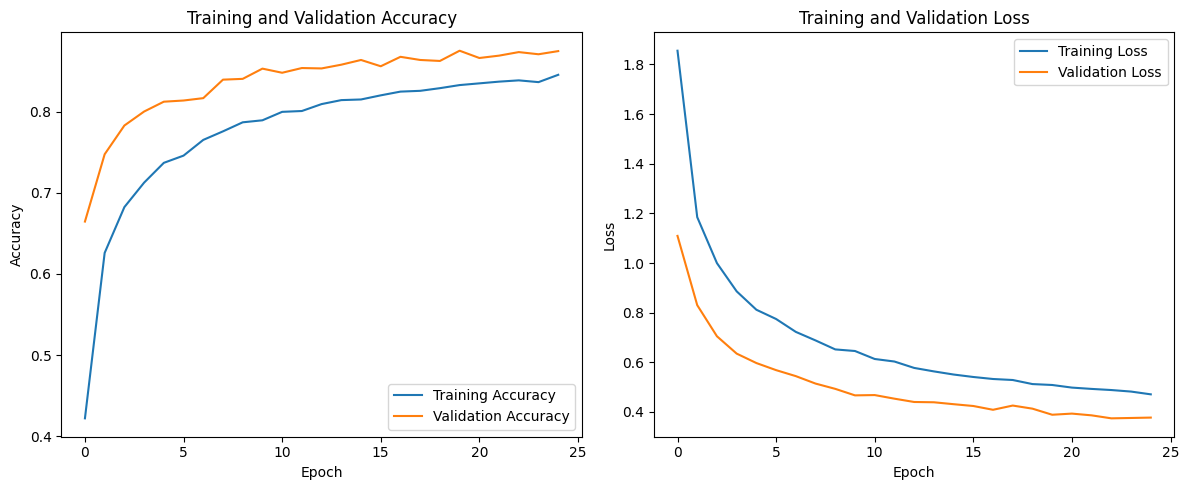

In [11]:
# Plot Training History
acc = history.history.get("accuracy", [])
val_acc = history.history.get("val_accuracy", [])
loss = history.history.get("loss", [])
val_loss = history.history.get("val_loss", [])

epochs_range = range(len(acc))

plt.figure(figsize=(12, 5))

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 1)
if acc and val_acc:
    plt.plot(epochs_range, acc, label="Training Accuracy")
    plt.plot(epochs_range, val_acc, label="Validation Accuracy")
    plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
if loss and val_loss:
    plt.plot(epochs_range, loss, label="Training Loss")
    plt.plot(epochs_range, val_loss, label="Validation Loss")
    plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.tight_layout()
plt.show()